<a href="https://colab.research.google.com/github/haiderzm/FaceMaskDetector/blob/main/MaskDetector_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2

In [ ]:
training_data = np.load('/content/gdrive/MyDrive/mask_training_data.npy', allow_pickle=True)

In [ ]:
print(len(training_data))

1256


In [ ]:
X,y = training_data[1001]

[0. 1.]


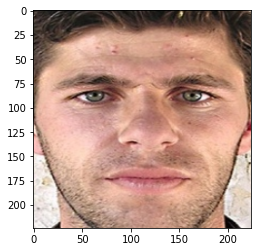

In [ ]:
plt.imshow(X)
print(y)

In [ ]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,3,224,224)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [ ]:
print(X[0].shape)

torch.Size([3, 224, 224])


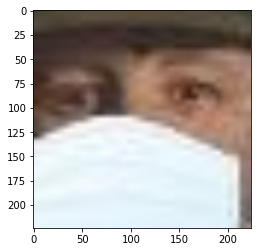

In [ ]:
plt.imshow(X[0].view(224,224,3))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
X, y = X.to(device), y.to(device)

In [ ]:
VAL_PCT = 0.1  
val_size = int(len(X)*VAL_PCT)
print(val_size)

125


In [ ]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [ ]:
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
from collections import OrderedDict

In [ ]:
fc = nn.Sequential(OrderedDict(
    [
     ('fc1', nn.Linear(25088,4096)),
     ('relu', nn.ReLU()),
     ('Dropout',nn.Dropout(p=0.5)),
     ('fc2', nn.Linear(4096,4096)),
     ('relu', nn.ReLU()),
     ('Dropout',nn.Dropout(p=0.5)),
     ('fc3', nn.Linear(4096,2)),
     ('output', nn.Softmax(dim=1))
    ]
))

In [ ]:
model.classifier = fc

In [ ]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_function = nn.MSELoss()

In [ ]:
def test_acc():
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = model(test_X[i].view(-1, 3, 224, 224))[0]  # returns a list, 
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print(correct,total)
    return correct/total*100

In [ ]:
BATCH_SIZE = 100
EPOCHS = 20

for epoch in range(EPOCHS):
    tot = 0
    cor = 0
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 3, 224, 224)
        batch_y = train_y[i:i+BATCH_SIZE]

        optimizer.zero_grad()

        outputs = model(batch_X)
        # print(outputs.shape)
        for x in range(len(outputs)):
            real_class  = torch.argmax(batch_y[x])
            pred_class = torch.argmax(outputs[x])
            if pred_class == real_class:
                cor+=1
            tot+=1
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update
    test_accuracy = test_acc()
    print(f"Epoch: {epoch}  Loss: {loss} Train-Accuracy: {cor/tot*100}   Test-Accuracy: {test_accuracy}")

100%|██████████| 125/125 [00:04<00:00, 30.46it/s]


116 125
Epoch: 0  Loss: 0.16239023208618164 Train-Accuracy: 81.6976127320955   Test-Accuracy: 92.80000000000001


100%|██████████| 125/125 [00:04<00:00, 30.75it/s]


119 125
Epoch: 1  Loss: 0.0831286758184433 Train-Accuracy: 92.13085764809902   Test-Accuracy: 95.19999999999999


100%|██████████| 125/125 [00:04<00:00, 30.91it/s]


117 125
Epoch: 2  Loss: 0.038702428340911865 Train-Accuracy: 94.16445623342176   Test-Accuracy: 93.60000000000001


100%|██████████| 125/125 [00:04<00:00, 30.91it/s]


118 125
Epoch: 3  Loss: 0.018749216571450233 Train-Accuracy: 95.49071618037135   Test-Accuracy: 94.39999999999999


100%|██████████| 125/125 [00:04<00:00, 30.83it/s]


117 125
Epoch: 4  Loss: 0.013894667848944664 Train-Accuracy: 96.02122015915118   Test-Accuracy: 93.60000000000001


100%|██████████| 125/125 [00:04<00:00, 30.86it/s]


119 125
Epoch: 5  Loss: 0.008822089992463589 Train-Accuracy: 96.46330680813439   Test-Accuracy: 95.19999999999999


100%|██████████| 125/125 [00:04<00:00, 30.99it/s]


121 125
Epoch: 6  Loss: 0.004772993735969067 Train-Accuracy: 97.25906277630415   Test-Accuracy: 96.8


100%|██████████| 125/125 [00:04<00:00, 30.98it/s]


120 125
Epoch: 7  Loss: 0.003977800719439983 Train-Accuracy: 97.70114942528735   Test-Accuracy: 96.0


100%|██████████| 125/125 [00:04<00:00, 30.84it/s]


122 125
Epoch: 8  Loss: 0.0025590884033590555 Train-Accuracy: 98.2316534040672   Test-Accuracy: 97.6


100%|██████████| 125/125 [00:04<00:00, 30.92it/s]


122 125
Epoch: 9  Loss: 0.001775195705704391 Train-Accuracy: 98.40848806366049   Test-Accuracy: 97.6


100%|██████████| 125/125 [00:04<00:00, 30.89it/s]


123 125
Epoch: 10  Loss: 0.0018873934168368578 Train-Accuracy: 98.93899204244032   Test-Accuracy: 98.4


100%|██████████| 125/125 [00:04<00:00, 30.90it/s]


121 125
Epoch: 11  Loss: 0.0019810087978839874 Train-Accuracy: 99.11582670203359   Test-Accuracy: 96.8


100%|██████████| 125/125 [00:04<00:00, 31.04it/s]


123 125
Epoch: 12  Loss: 0.0010786002967506647 Train-Accuracy: 99.11582670203359   Test-Accuracy: 98.4


100%|██████████| 125/125 [00:04<00:00, 30.97it/s]


122 125
Epoch: 13  Loss: 0.0013285428285598755 Train-Accuracy: 99.46949602122017   Test-Accuracy: 97.6


100%|██████████| 125/125 [00:04<00:00, 31.02it/s]


123 125
Epoch: 14  Loss: 0.0008074347861111164 Train-Accuracy: 99.55791335101681   Test-Accuracy: 98.4


100%|██████████| 125/125 [00:04<00:00, 30.99it/s]


123 125
Epoch: 15  Loss: 0.000865443202201277 Train-Accuracy: 99.64633068081345   Test-Accuracy: 98.4


100%|██████████| 125/125 [00:04<00:00, 30.94it/s]


125 125
Epoch: 16  Loss: 0.0005644871853291988 Train-Accuracy: 99.73474801061008   Test-Accuracy: 100.0


100%|██████████| 125/125 [00:04<00:00, 30.85it/s]


122 125
Epoch: 17  Loss: 0.000730270694475621 Train-Accuracy: 99.82316534040672   Test-Accuracy: 97.6


100%|██████████| 125/125 [00:04<00:00, 30.97it/s]


123 125
Epoch: 18  Loss: 0.0005869542364962399 Train-Accuracy: 99.73474801061008   Test-Accuracy: 98.4


100%|██████████| 125/125 [00:04<00:00, 30.98it/s]

125 125
Epoch: 19  Loss: 0.0005362051888369024 Train-Accuracy: 99.82316534040672   Test-Accuracy: 100.0


tensor([[0.0064, 0.9936]], device='cuda:0', grad_fn=<SoftmaxBackward>)


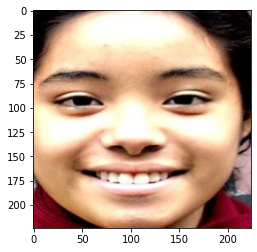

In [ ]:
i = 100
print(model(test_X[i].view(-1,3,224,224)))
# print(y[1])
plt.imshow(test_X[i].cpu().view(224,224,3))

In [ ]:
torch.save(model.state_dict(), 'vgg16-facemask_v3.pt')

In [ ]:
model.load_state_dict(torch.load('vgg16-facemask_v3.pt'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(model(test_X[5].view(-1,3,224,224)))
print(test_y[5])

tensor([[9.9909e-01, 9.0645e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([1., 0.], device='cuda:0')


In [ ]:
!cp vgg16-facemask_v3.pt /content/gdrive/MyDrive/

(224, 224, 3)


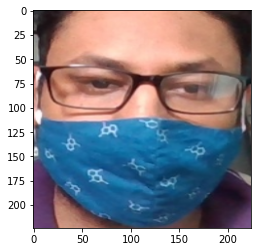

In [ ]:
img = cv2.imread('face.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224,224))
print(img.shape)
img_tensor = torch.Tensor(img).view(1,3,224,224)
img_tensor /= 255.
# print(img_tensor)
# print()
plt.imshow(img_tensor.view(224,224,3))
# plt.imshow(img)

In [ ]:
img_tensor = img_tensor.to(device)

In [ ]:
model(img_tensor)

tensor([[0.7189, 0.2811]], device='cuda:0', grad_fn=<SoftmaxBackward>)